Total SKUs tested: 30490
Lenient rule  (ADF p>0.05 OR  KPSS p<0.05): 26420 (86.7%)
Strict rule   (ADF p>0.10 AND KPSS p<0.05): 2731  (9.0%)


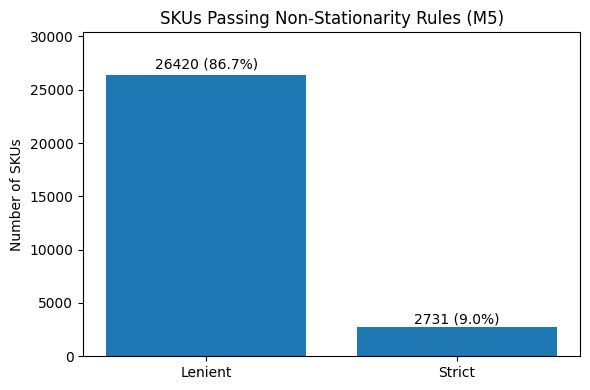

Saved 500 strict non-stationary, diverse SKUs to: /ceph/bjangoll/thesis/Data/M5_datasets/m5_ns.csv

Preview:


,cluster,series_id,adf_p,kpss_p,mean,std,zero_rate,item_id,dept_id,cat_id,store_id,state_id
0,0,CA_2_FOODS_3_294,0.229842,0.01,0.643492,1.763138,0.812859,FOODS_3_294,FOODS_3,FOODS,CA_2,CA
1,1,CA_2_HOUSEHOLD_1_079,0.221186,0.01,1.127026,1.471125,0.470988,HOUSEHOLD_1_079,HOUSEHOLD_1,HOUSEHOLD,CA_2,CA
2,2,CA_3_HOUSEHOLD_1_277,0.161521,0.01,14.510716,14.380463,0.311553,HOUSEHOLD_1_277,HOUSEHOLD_1,HOUSEHOLD,CA_3,CA
3,3,WI_1_FOODS_3_006,0.354234,0.01,0.291166,0.655038,0.797177,FOODS_3_006,FOODS_3,FOODS,WI_1,WI
4,4,TX_1_HOUSEHOLD_1_043,0.123243,0.01,0.164663,0.642269,0.908521,HOUSEHOLD_1_043,HOUSEHOLD_1,HOUSEHOLD,TX_1,TX



KPSS p-value summary (selected):
count    500.000000
mean       0.010016
std        0.000352
min        0.010000
25%        0.010000
50%        0.010000
75%        0.010000
max        0.017874
Name: kpss_p, dtype: float64


In [ ]:
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tools.sm_exceptions import InterpolationWarning

warnings.simplefilter("ignore", InterpolationWarning)


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, kpss
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans

# CONFIG (M5 paths)
SALES_CSV   = "C:\\Users\\Bindhu\\Documents\\!Thesis\\m5_final\\Data\\raw_data\\sales_train_validation.csv" 
CAL_CSV     = "C:\\Users\\Bindhu\\Documents\\!Thesis\\m5_final\\Data\\raw_data\\calendar.csv"         
OUT_CSV     = "C:\\Users\\Bindhu\\Documents\\!Thesis\\m5_final\\Data\\m5_ns.csv"
MIN_LEN_TS  = 1000
N_CLUSTERS  = 500
RANDOM_STATE = 42

# Loading data 
sales = pd.read_csv(SALES_CSV)
# Identifying day columns
d_cols = [c for c in sales.columns if c.startswith("d_")]
# Basic metadata
meta_cols = ["item_id", "dept_id", "cat_id", "store_id", "state_id"]


# Building series_id
sales["series_id"] = sales["store_id"].astype(str) + "_" + sales["item_id"].astype(str)

# Stationarity tests per series
# Defining a helper that runs ADF and KPSS on a numeric sequence with basic guards
def run_adf_kpss(ts):
    ts = np.asarray(ts, dtype=float)
    ts = ts[~np.isnan(ts)]
    # Skipping short sequences because unit root tests are unstable with few points
    if ts.size < MIN_LEN_TS:
        return np.nan, np.nan
    try:
        # ADF: H0 is unit root (non-stationary). High p means fail to reject unit root
        adf_p = adfuller(ts, autolag="AIC")[1]
    except Exception:
        adf_p = np.nan
    try:
        # KPSS: H0 is stationarity. Low p means reject stationarity
        kpss_p = kpss(ts, regression="c", nlags="auto")[1]
    except Exception:
        kpss_p = np.nan
    return adf_p, kpss_p

# Extracting time series array row-wise
series_ids = sales["series_id"].to_numpy()
X_series   = sales[d_cols].to_numpy(dtype=float)

# Preparing arrays to store test p-values for each series
adf_ps = np.empty(len(series_ids)); adf_ps.fill(np.nan)
kpss_ps = np.empty(len(series_ids)); kpss_ps.fill(np.nan)

# Looping over all series to compute ADF and KPSS p-values
for i in range(len(series_ids)):
    ts = X_series[i]
    a, k = run_adf_kpss(ts)
    adf_ps[i]  = a
    kpss_ps[i] = k

stationarity_df = pd.DataFrame({
    "series_id": series_ids,
    "adf_p": adf_ps,
    "kpss_p": kpss_ps
}).drop_duplicates("series_id")  # just in case

total = len(stationarity_df)
# Defining two selection rules:
#   lenient: non-stationary by ADF (fail to reject unit root) or KPSS rejects stationarity
#   strict : non-stationary by ADF at 10% and KPSS rejects stationarity at 5%
lenient_mask = (stationarity_df['adf_p'] > 0.05) | (stationarity_df['kpss_p'] < 0.05)
strict_mask  = (stationarity_df['adf_p'] > 0.10) & (stationarity_df['kpss_p'] < 0.05)

# Counting how many series satisfy each rule
n_lenient = int(lenient_mask.sum())
n_strict  = int(strict_mask.sum())

print(f"Total SKUs tested: {total}")
print(f"Lenient rule  (ADF p>0.05 OR  KPSS p<0.05): {n_lenient} ({n_lenient/total:.1%})")
print(f"Strict rule   (ADF p>0.10 AND KPSS p<0.05): {n_strict}  ({n_strict/total:.1%})")

# Drawing a simple bar chart to contrast the two rules visually
plt.figure(figsize=(6,4))
bars = plt.bar(["Lenient","Strict"], [n_lenient, n_strict])
plt.title("SKUs Passing Non-Stationarity Rules (M5)")
plt.ylabel("Number of SKUs")
plt.ylim(0, max(n_lenient, n_strict) * 1.15 if max(n_lenient, n_strict) > 0 else 1)
for bar, c in zip(bars, [n_lenient, n_strict]):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height()*1.01,
             f'{c} ({(c/total if total else 0):.1%})', ha='center', va='bottom')
plt.tight_layout()
plt.show()

if n_strict < N_CLUSTERS:
    print(f"WARNING: Only {n_strict} SKUs meet the strict rule; backfilling will be used to reach {N_CLUSTERS}.")

# Strict pool (unambiguously non-stationary)
strict_pool = stationarity_df.loc[strict_mask].dropna().copy()

means      = np.nanmean(X_series, axis=1)
stds       = np.nanstd(X_series, axis=1, ddof=0)
zero_rates = np.mean(X_series == 0, axis=1)

stats_df = pd.DataFrame({
    "series_id": series_ids,
    "mean": means,
    "std": stds,
    "zero_rate": zero_rates
}).drop_duplicates("series_id")

strict_pool = strict_pool.merge(stats_df, on="series_id", how="left")

# Metadata join
meta = sales[["series_id"] + meta_cols].drop_duplicates("series_id")
strict_pool = strict_pool.merge(meta, on="series_id", how="left")

if strict_pool.empty:
    raise RuntimeError("No SKUs meet the strict rule; relax thresholds or use the lenient pool.")

# Feature matrix for clustering
# Using M5-available categoricals
cat_cols = ["dept_id", "cat_id", "store_id", "state_id"]
num_cols = ["mean", "std", "zero_rate"]

missing_cats = [c for c in cat_cols if c not in strict_pool.columns]
if missing_cats:
    raise KeyError(f"Missing categorical metadata columns: {missing_cats}")

# One-hot encoding categoricals to convert them into numeric indicators
ohe = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
X_cat = ohe.fit_transform(strict_pool[cat_cols])

# Standardizing numeric columns so each has comparable scale
scaler = StandardScaler()
X_num = scaler.fit_transform(strict_pool[num_cols])

X = np.hstack([X_cat, X_num])

# PCA + KMeans
# Reducing dimensionality with PCA to stabilize clustering in high dimensions
n_comp = min(50, X.shape[1]-1) if X.shape[1] > 1 else 1
pca = PCA(n_components=n_comp, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X)

# Setting the number of clusters
n_clusters_eff = min(N_CLUSTERS, len(strict_pool))
# Running MiniBatchKMeans for scalable clustering on large inputs
km = MiniBatchKMeans(n_clusters=n_clusters_eff,
                     random_state=RANDOM_STATE,
                     batch_size=max(10000, n_clusters_eff*5),
                     n_init="auto")
labels = km.fit_predict(X_pca)
strict_pool["cluster"] = labels

# Within each cluster, picking SKU with LOWEST KPSS p (strongest non-stationarity)
selected = (strict_pool.sort_values(["cluster","kpss_p"], ascending=[True, True])
                      .groupby("cluster", as_index=False)
                      .first())

# Backfilling to reach N_CLUSTERS if needed
if len(selected) < N_CLUSTERS:
    missing = N_CLUSTERS - len(selected)
    used = set(selected["series_id"])
    backfill = (strict_pool[~strict_pool["series_id"].isin(used)]
                .sort_values("kpss_p", ascending=True)
                .head(missing))
    selected = pd.concat([selected, backfill], ignore_index=True)

selected[["series_id"]].to_csv(OUT_CSV, index=False)
print(f"Saved {len(selected)} strict non-stationary, diverse SKUs to: {OUT_CSV}")

print("\nPreview:")
try:
    from IPython.display import display
    display(selected.head())
except Exception:
    print(selected.head())

print("\nKPSS p-value summary (selected):")
print(selected["kpss_p"].describe())